# Modification of sequence speed by adding additional forward excitation to subsequent assembly

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_5_SpeedOfCooperatingSequences_WithFFExcitationToSubsequentAssembly import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import tools_plot
plt.rc('text', usetex = True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rcParams.update({'font.size': 20})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
t = params['t']

fname_r = 'data/5_r_EE_EEdelta1.pckl'
fname_M = 'data/5_M_EE_EEdelta1.pckl'

In [3]:
load_res = False

if load_res:
    r = tools_wc.load_pckl(fname_r)
    M = tools_wc.load_pckl(fname_M)
    
else:

    r = np.zeros([
        len(params['range_pot_pairing_EE']),
        len(params['range_pot_pairing_EE_delta1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])
    
    M = np.zeros([
        len(params['range_pot_pairing_EE']),
        len(params['range_pot_pairing_EE_delta1']),
    ], dtype=object)

    for i, pot_EE in enumerate(tqdm(params['range_pot_pairing_EE'])):
        for j, pot_EE_delta1 in enumerate(params['range_pot_pairing_EE_delta1']):
            sim = sim_wc.Simulator(params)
            sim.set_interaction_matrix()
            # pair sequences
            # EE pairing of coactive assemblies
            sim.pair_sequences(
                pos_sender=1,
                pos_target=2,
                pot=pot_EE,
                type_proj=params['type_proj'][0],
                delta_assembly=0)
            sim.pair_sequences(
                pos_sender=2,
                pos_target=1,
                pot=pot_EE,
                type_proj=params['type_proj'][0],
                delta_assembly=0) 
            ## EE pairing to subsequent assembly
            sim.pair_sequences(
                pos_sender=1,
                pos_target=2,
                pot=pot_EE_delta1,
                type_proj=params['type_proj'][1],
                delta_assembly=1)
            sim.pair_sequences(
                pos_sender=2,
                pos_target=1,
                pot=pot_EE_delta1,
                type_proj=params['type_proj'][1],
                delta_assembly=1) 
            
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
            
            M[i, j] = sim.M
    tools_wc.save_pckl(r, fname_r)
    tools_wc.save_pckl(M, fname_M)

100%|███████████████████████████████████████████████████████████████████| 40/40 [09:34<00:00, 14.36s/it]


In [4]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_pot_pairing_EE']),
    len(params['range_pot_pairing_EE_delta1']),
    len(params['seqs'])
], dtype=bool)

dt = np.mean(np.unique(np.diff(params['t'])))

for i in tqdm(range(len(params['range_pot_pairing_EE']))):
    for j in range(len(params['range_pot_pairing_EE_delta1'])):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            crit[i, j, m] = tools_wc.peak_criterium(rE_ijm, params['r_min'], seq_m_pos, params['tol'])

100%|███████████████████████████████████████████████████████████████████| 40/40 [03:16<00:00,  4.92s/it]


In [5]:
crit_12lumped = np.zeros([
    len(params['range_pot_pairing_EE']),
    len(params['range_pot_pairing_EE_delta1']),
    2
], dtype=bool)

In [6]:
crit_12lumped[:,:,0] = crit[:,:,0]
crit_12lumped[:,:,1] = np.logical_and(crit[:,:,1], crit[:,:,2])

In [7]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [8]:
ar_examples = np.array([
#    [0.1e-2, 1.7e-2],
    [0., 1.9e-2],
    [1.3e-2, 1.9e-2],
    [3.e-2, 1.9e-2],
    [3.e-2, 0.3e-2],
]) # x, y

/tmp/ipykernel_2281/3970999420.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


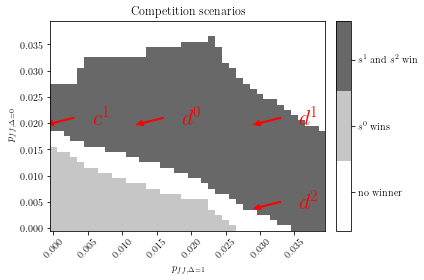

In [9]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(6,4))


ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$') # modify name
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Competition scenarios')


#ax[0,0].set_aspect('equal')
X, Y = np.meshgrid(
    params['range_pot_pairing_EE_delta1']*params['p_ff'],
    params['range_pot_pairing_EE']*params['p_ff'])
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    piv, cmap=cmap, norm=norm)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=[0, 0.9, 1.1, 2.],
    values=[0, 0.9, 1.1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

# draw arrows
dx, dy = -3e-3, -1e-3
head_length = 1e-3
for i, ex_i in enumerate(ar_examples):
    p_ffdelta1_i, p_ff_i = ex_i
    ax[0,0].arrow(
        p_ffdelta1_i-dx, p_ff_i-dy+head_length,
        dx, dy,
        color='r',
        width=2e-4,
        head_width=1e-3,
        head_length=1e-3)

    if i == 0:
        txt = r'$c^'+str(i+1)+'$'
    else:
        txt = r'$d^'+str(i-1)+'$'
    ax[0,0].text(
        p_ffdelta1_i+7e-3, p_ff_i+0e-3,
        txt,
        color='r', fontsize=22,
        horizontalalignment='center',
        verticalalignment='bottom')

fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_compscenario.svg')

In [10]:
norm

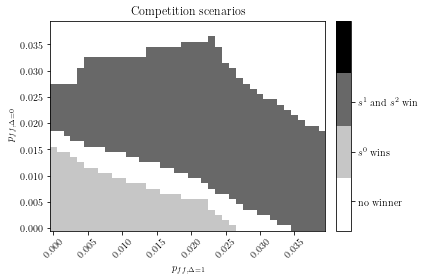

In [11]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(6,4))


ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$') # modify name
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Competition scenarios')


#ax[0,0].set_aspect('equal')
X, Y = np.meshgrid(
    params['range_pot_pairing_EE_delta1']*params['p_ff'],
    params['range_pot_pairing_EE']*params['p_ff'])
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    piv, cmap=cmap, norm=norm)

ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_compscenario_noarrows.svg')

## Activities of examples 

In [12]:
ls_title = [
    r'$c^1$',
    r'$d^0$',
    r'$d^1$',
    r'$d^2$',
]

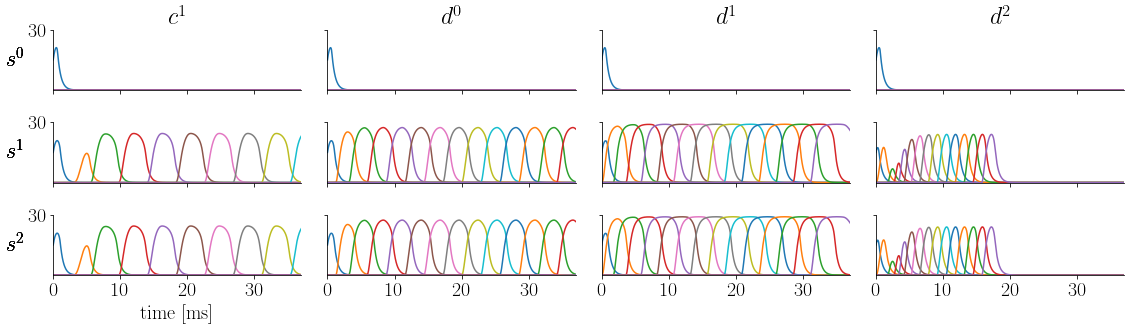

In [29]:
fig, ax = plt.subplots(
    len(params['seqs']),
    len(ar_examples),
    sharex=True, sharey=True,
    figsize=(16, 5)
)

ax[0, 0].set_xlim(0, 37.)
ax[0, 0].set_yticks([30])
ax[0, 0].set_ylim(0, 30)

for i, ex_i in enumerate(ar_examples):
    p_ffdelta1_i, p_ff_i = ex_i
    idx_p_ff_i = np.where(
        np.abs(params['range_pot_pairing_EE']*params['p_ff']-p_ff_i)<1e-10
        )[0][0]
    idx_p_ffdelta1_i = np.where(
        np.abs(params['range_pot_pairing_EE_delta1']*params['p_ff']-p_ffdelta1_i)<1e-10
        )[0][0]
    ax[0, i].set_title(ls_title[i])
    for j, seq_j in enumerate(params['seqs']):
        ax[j, 0].text(
            -0.15, 0.5,
            r'$s^'+str(j)+'$',
            fontsize=22, rotation=0,
            va='center', ha='center',
            transform=ax[j, 0].transAxes)

        for idx_ass_ex_j in seq_j[::2]:
            ax[j, i].plot(
                params['t'],
                rE[idx_p_ff_i, idx_p_ffdelta1_i, :, idx_ass_ex_j])
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['top'].set_visible(False)
ax[-1, 0].set_xlabel('time [ms]')

fig.tight_layout()
fig.savefig('figures/5c_Speed_EE_EE_delta1_examples.svg')

## Mean activation time

In [14]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EE_delta1'])

ar_mean_act_time = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_mean_act_time[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

/tmp/ipykernel_2281/2582332280.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


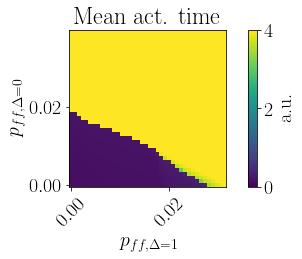

In [30]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$')
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Mean act. time')

ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    X, 
    Y,
    ar_mean_act_time,
    vmin=0.,
    vmax=4.)
#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')
fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_mean_activation_time.svg')

## Ratio of activated assemblies

In [16]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EE_delta1'])

ar_n_active = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        ar_n_active[i, j] = tools_wc.number_active(r_ij, params['r_min'])
        
ar_ratio_active = ar_n_active/len(seq)

/tmp/ipykernel_2281/1956425511.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


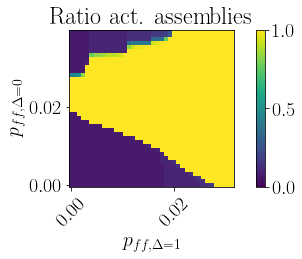

In [31]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$')
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Ratio act. assemblies')

heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    ar_ratio_active,
    vmin=0)


#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_ratio_active.svg')

In [18]:
np.median(ar_ratio_active)

1.0

## Activation time of first assembly

In [19]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EE_delta1'])

ar_act_time_first = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq[0,]].T
        ar_act_time_first[i, j] = tools_wc.mean_activation_time(r_ij, params['r_min'], dt)

/tmp/ipykernel_2281/2622624168.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


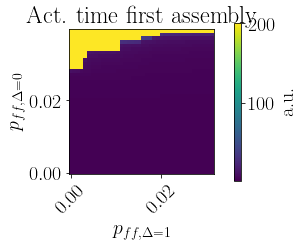

In [32]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.6,4))

ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$')
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Act. time first assembly ')


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    ar_act_time_first)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())


cb = fig.colorbar(heatmap, cax=ax[0,1])
ax[0,1].set_ylabel('a.u.')
fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_activationtimefirstassembly.svg')

## Sequence speed

In [21]:
n_i = len(params['range_pot_pairing_EE'])
n_j = len(params['range_pot_pairing_EE_delta1'])

seq_speed = np.empty((n_i, n_j), dtype=float)
dt = np.round(np.median(np.diff(params['t'])),4)
seq = params['seqs'][1]

for i in range(n_i):
    for j in range(n_j):
        r_ij = rE[i, j, :, seq].T
        seq_speed[i, j] = tools_wc.sequence_speed(r_ij, params['r_min'], params['tol'], dt)

/home/jovyan/work/sequence_competition_cooperation/tools_wc.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  speed = 1./np.median(intrvls)


In [22]:
# normalize sequence speed by example sequence c0

p_ffdelta1_i, p_ff_i = ar_examples[0]

idx_p_ff_i = np.where(
    np.abs(params['range_pot_pairing_EE']*params['p_ff']-p_ff_i)<1e-10
    )[0][0]
idx_p_ffdelta1_i = np.where(
    np.abs(params['range_pot_pairing_EE_delta1']*params['p_ff']-p_ffdelta1_i)<1e-10
    )[0][0]

seq_speed_i = seq_speed[idx_p_ff_i, idx_p_ffdelta1_i]

seq_speed_normalized = seq_speed/seq_speed_i

/tmp/ipykernel_2281/931215504.py:8: RuntimeWarning: invalid value encountered in multiply
  seq_speed_normalized_12 = seq_speed_normalized*crit_12lumped[:,:,1]
/tmp/ipykernel_2281/931215504.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


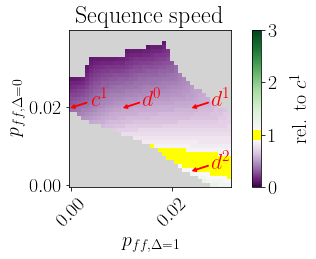

In [33]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.8,4))

ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$')
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Sequence speed')

# limit sequence speed to scenarios where s1 and s2 win
seq_speed_normalized_12 = seq_speed_normalized*crit_12lumped[:,:,1]

# Set nan values outside this areaSequence speed can be influence by additional interactions. a) b)
seq_speed_normalized_12[~crit_12lumped[:,:,1]] = np.nan

cmap = tools_plot.get_diverging_colormap(
    vmin=0.,
    vmax=3.,
    center=1.,
    boundary_low=0.9,
    boundary_high=1.1,
    color_center=[1, 1., 0, 1])
cmap.set_bad('lightgrey')

heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    seq_speed_normalized_12,
    cmap=cmap,
    vmin=0,
    vmax=3,
)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())

# draw arrows
dx, dy = -3e-3, -1e-3
head_length = 1e-3
for i, ex_i in enumerate(ar_examples):
    p_ffdelta1_i, p_ff_i = ex_i
    ax[0,0].arrow(
        p_ffdelta1_i-dx+head_length, p_ff_i-dy+head_length,
        dx, dy,
        color='r',
        width=2e-4,
        head_width=1e-3,
        head_length=1e-3)
    
    if i == 0:
        txt = r'$c^'+str(i+1)+'$'
    else:
        txt = r'$d^'+str(i-1)+'$'
    ax[0,0].text(
        p_ffdelta1_i+7e-3, p_ff_i+0e-3,
        txt,
        color='r', fontsize=22,
        horizontalalignment='center',
        verticalalignment='bottom')

cb = fig.colorbar(heatmap, cax=ax[0,1])
cb.set_label('rel. to $c^1$', rotation=90, labelpad=15)

fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_seqspeed_relc1.svg')

### Normalize to sequence speed c0, determined from Notebook 4.

In [26]:
# normalize sequence speed by example sequence c0

seq_speed_i = 1.3157894736842106



seq_speed_normalized = seq_speed/seq_speed_i

/tmp/ipykernel_2281/2951656354.py:8: RuntimeWarning: invalid value encountered in multiply
  seq_speed_normalized_12 = seq_speed_normalized*crit_12lumped[:,:,1]
/tmp/ipykernel_2281/2951656354.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels, rotation=45)


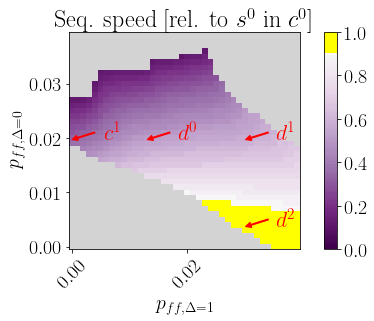

In [34]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(4.8,4))

ax[0,0].set_ylabel(r'$p_{ff,\Delta=0}$')
ax[0,0].set_xlabel(r'$p_{ff,\Delta=1}$')
ax[0,0].set_title(r'Seq. speed [rel. to $s^0$ in $c^0]$')

# limit sequence speed to scenarios where s1 and s2 win
seq_speed_normalized_12 = seq_speed_normalized*crit_12lumped[:,:,1]

# Set nan values outside this areaSequence speed can be influence by additional interactions. a) b)
seq_speed_normalized_12[~crit_12lumped[:,:,1]] = np.nan

cmap = tools_plot.get_onesided_colormap(
    vmin=0.,
    vmax=3.,
    center=1.,
    boundary_low=0.9,
    boundary_high=1.0,
    color_center=[1, 1., 0, 1])
cmap.set_bad('lightgrey')

heatmap = ax[0,0].pcolormesh(
    X,
    Y,
    seq_speed_normalized_12,
    cmap=cmap,
    vmin=0,
    vmax=1,
)

#ax[0,0].set_xticks(ax[0,0].get_yticks())
fig.canvas.draw()
labels = [item.get_text() for item in ax[0,0].get_xticklabels()]
ax[0,0].set_xticklabels(labels, rotation=45)
ax[0,0].set_xlim(ax[0,0].get_ylim())

# draw arrows
dx, dy = -3e-3, -1e-3
head_length = 1e-3
for i, ex_i in enumerate(ar_examples):
    p_ffdelta1_i, p_ff_i = ex_i
    ax[0,0].arrow(
        p_ffdelta1_i-dx+head_length, p_ff_i-dy+head_length,
        dx, dy,
        color='r',
        width=2e-4,
        head_width=1e-3,
        head_length=1e-3)
    
    if i == 0:
        txt = r'$c^'+str(i+1)+'$'
    else:
        txt = r'$d^'+str(i-1)+'$'
    ax[0,0].text(
        p_ffdelta1_i+7e-3, p_ff_i+0e-3,
        txt,
        color='r', fontsize=22,
        horizontalalignment='center',
        verticalalignment='bottom')

cb = fig.colorbar(heatmap, cax=ax[0,1])
#cb.set_label('rel. to $s^0$ in $c^0$', rotation=90, labelpad=15)

#fig.tight_layout()

fig.savefig('figures/5b_Speed_EE_EE_delta1_seqspeed_relc0.svg')